# CNN+LSTM 전력 수요 예측 

### <목차>

### <화면 가로 확장>

In [1]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import time
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split
from scipy.stats import norm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, LSTM, Bidirectional, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.wrappers import TimeDistributed
import keras

In [2]:
def SimpleGraph(title, plot, ylabel, savename):
    plt.figure(figsize=(150,20))
    plt.grid()
    plt.title(title, fontsize=180)
    plt.plot(plot)

    plt.xlabel("Time by Hour", fontsize=130)
    plt.ylabel(ylabel, fontsize=130)
    plt.margins(x=0.002)

    plt.xticks(list_24, labels=np.arange(24))

    plt.tick_params(axis='x', size=15)
    plt.tick_params(axis='x', labelsize=70)
    plt.tick_params(axis='y', size=15)
    plt.tick_params(axis='y', labelsize=70)
    plt.savefig("./Result/"+savename+".png", bbox_inches='tight',pad_inches=1)
    plt.show()

In [3]:
Data_4Y_Edited = pd.read_csv('./Combined_Data_New/House1_Ch1_Combined_Data_New_13-16_Outlier_Edited.csv', encoding='cp949')
Data_4Y_Edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   Year-Month-Date  object 
 2   Time             object 
 3   Holiday          int64  
 4   Watt             float64
 5   Temp('C)         float64
 6   Humidity(%)      float64
 7   CPI              float64
dtypes: float64(4), int64(2), object(2)
memory usage: 128.3+ MB


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

### 편하게 학습하기 위한 함수(추후 본문 합류 및 삭제)

In [9]:
def Auto_Scaler_lr_filt_kernel_merge_case(scaler_name, lr, filt, kernel, mode, case):
    start=datetime.datetime.now()
    print(start, "\n")
    Data_4Y_Edited.sort_index(ascending=False).reset_index(drop=True)
    from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
    scaler=scaler_name

    scale_cols = ["Holiday", "Watt", "Temp('C)", "Humidity(%)", "CPI"]
    Data_4Y_scaled = scaler.fit_transform(Data_4Y_Edited[scale_cols])
    Data_4Y_scaled = pd.DataFrame(Data_4Y_scaled)
    Data_4Y_scaled.columns = scale_cols
    Data_4Y_scaled.insert(2, "Watt2", Data_4Y_scaled["Watt"])
    if case==1:
        Data_4Y_scaled=Data_4Y_scaled[["Watt", "Watt2"]]
    if case==2:
        Data_4Y_scaled=Data_4Y_scaled[["Watt", "Temp('C)", "Watt2"]]
    if case==3:
        Data_4Y_scaled=Data_4Y_scaled[["Watt", "Humidity(%)", "Watt2"]]
    if case==4:
        Data_4Y_scaled=Data_4Y_scaled[["Watt", "Humidity(%)", "Watt2"]]
    if case==5:
        Data_4Y_scaled=Data_4Y_scaled[["Watt", "Temp('C)", "Humidity(%)", "Watt2"]]
    if case==6:
        Data_4Y_scaled=Data_4Y_scaled[["Watt", "Temp('C)", "Humidity(%)", "Holiday", "Watt2"]]
    Data_4Y_scaled.info()
    
    #=================================================================================
    TEST_SIZE = 1*60*24*365 #1년치를 테스트셋으로 사용
    WINDOW_SIZE = 7
    BATCH_SIZE = 32
    VAL_DAYS = 525600

    learning = Data_4Y_scaled[:-TEST_SIZE] # 학습에 쓰이는 전체 데이터
    VAL_RATIO=VAL_DAYS/len(learning)
    VAL_SIZE = int(len(learning)*VAL_RATIO)
    TRAIN = learning[:-VAL_SIZE]
    VAL = learning[-VAL_SIZE:]
    TEST = Data_4Y_scaled[-TEST_SIZE:]

    train_data = windowed_dataset(TRAIN, WINDOW_SIZE, BATCH_SIZE, False) 
    valid_data = windowed_dataset(VAL, WINDOW_SIZE, BATCH_SIZE, True)
    test_data = windowed_dataset(TEST, WINDOW_SIZE, BATCH_SIZE, False)

    #===========================================================================
    LeakyReLU=tf.keras.layers.LeakyReLU(alpha=0.1)

    model = Sequential([
        Conv1D(filters=filt, kernel_size=kernel, padding="causal", activation=LeakyReLU, input_shape=[WINDOW_SIZE, TRAIN.shape[1]]),
        MaxPooling1D(pool_size=2, strides=1, padding="same"),
        Conv1D(filters=filt, kernel_size=kernel, padding="causal", activation=LeakyReLU),
        MaxPooling1D(pool_size=2, strides=1, padding="same"),
        Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode=mode),
        TimeDistributed(Dense(8)),
        Bidirectional(LSTM(4, activation=LeakyReLU, return_sequences=True), merge_mode=mode),
        TimeDistributed(Dense(4)),
        Bidirectional(LSTM(2, activation=LeakyReLU, return_sequences=False), merge_mode=mode),
        Dense(1)
                        ])
    Nadam = tf.keras.optimizers.Nadam(learning_rate=lr)
    model.compile(loss='mean_absolute_error', optimizer=Nadam)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10)
    with tf.device('/GPU:0'):
        model_path = 'model'
        filename = os.path.join(model_path, "tmp_checkpoint_CL_"+str(scaler_name)+"_"+str(lr)+"_"+str(filt)+"_"+str(kernel)+"_"+mode+"_"+str(case)+".h5")
        checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
        history = model.fit(train_data, epochs=10, batch_size=BATCH_SIZE, validation_data=(valid_data), callbacks=[checkpoint, early_stop])

    model.load_weights(filename)
    pred = model.predict(test_data)
    pred.shape
    #================================================================================================================
    plt.figure(figsize=(16, 10))
    plt.title('Model Loss Convergence Graph', size='15')
    y_tloss = history.history['loss']
    y_vloss = history.history['val_loss']
    x_len = np.arange(len(y_tloss))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    #plt.xticks(range(0,50,10), labels=range(1,21, 10))

    plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
    plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
    plt.margins(x=0.02)
    plt.legend(['Training loss', 'Validation loss'])
    plt.savefig("./Result/CNN+LSTM/Graph/Model_Loss_Convergence_Graph_"+str(scaler_name)+"_"+str(lr)+"_"+str(filt)+"_"+str(kernel)+"_"+mode+"_"+str(case)+".png")

    #=================================================================================================================
    fig = plt.figure(figsize=(300,15)) 
    ax1 = fig.add_subplot() # subplot 그래프 생성
    ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
    plt.yticks([0, 0.111, 0.222, 0.333, 0.444, 0.555, 0.666, 0.777, 0.888, 1.0], 
               labels=['0', '1000 W', '2000 W', '3000 W', '4000 W', '5000 W', '6000 W', '7000 W', '8000 W','9000 W'])

    color1 = 'darkorange'
    ax1.plot(TEST['Watt'][:-WINDOW_SIZE], color=color1)
    ax1.tick_params(axis='y')
    ax1.tick_params(axis='x', size=20, labelsize=20)
    ax1.margins(x=0.005)

    ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.995, 1, 0, 0))

    color2 = 'blue'
    ax2 = ax1.twiny()
    ax2.plot(pred, color=color2)
    ax2.tick_params(axis='x', size=20, labelsize=20)
    ax2.margins(x=0.005)

    ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))

    plt.savefig("./Result/CNN+LSTM/Graph/Pred_with_Actual_"+str(scaler_name)+"_"+str(lr)+"_"+str(filt)+"_"+str(kernel)+"_"+mode+"_"+str(case)+".png")
    
    from sklearn.metrics import r2_score as r2
    from sklearn.metrics import mean_absolute_error as MAE
    from sklearn.metrics import mean_squared_error as MSE
    def SMAPE(y_test, y_pred):
        return np.mean((np.abs(y_test-y_pred))/(np.abs(y_test)+np.abs(y_pred)))*100/2
    
    true = TEST['Watt'][:-WINDOW_SIZE].to_numpy()
    true = true.reshape(-1,1)

    MAE = MAE(true, pred)
    RMSE = np.sqrt(MSE(true, pred))
    SMAPE0 = SMAPE(true, pred)
    
    print('\nr2 >> %.4f' %r2(true, pred)) # 1에 가까워야 좋음
    print('MAE >> %.4f' %MAE) # 0에 가까워야 좋음
    print('RMSE >> %.4f' %RMSE) # 0에 가까워야 좋음
    print('SMAPE >> %.4f' %SMAPE0) # 0에 가까워야 좋음
    end=datetime.datetime.now()
    print("\n소요시간 >>", end-start)

2022-09-03 22:59:05.708325 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2102400 entries, 0 to 2102399
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Watt         float64
 1   Temp('C)     float64
 2   Humidity(%)  float64
 3   Holiday      float64
 4   Watt2        float64
dtypes: float64(5)
memory usage: 80.2 MB
Epoch 1/10
  32850/Unknown - 4554s 138ms/step - loss: 0.2503
Epoch 00001: val_loss improved from inf to 0.25007, saving model to model\tmp_checkpoint_CL_QuantileTransformer()_0.0004_8_4_ave_6.h5
32850/32850 [==============================] - 4871s 148ms/step - loss: 0.2503 - val_loss: 0.2501
Epoch 2/10
32850/32850 [==============================] - ETA: 0s - loss: 0.2452
Epoch 00002: val_loss improved from 0.25007 to 0.24407, saving model to model\tmp_checkpoint_CL_QuantileTransformer()_0.0004_8_4_ave_6.h5
32850/32850 [==============================] - 4825s 147ms/step - loss: 0.2452 - val_loss: 0.2441
Epoch 3/10
32850/32850 [==

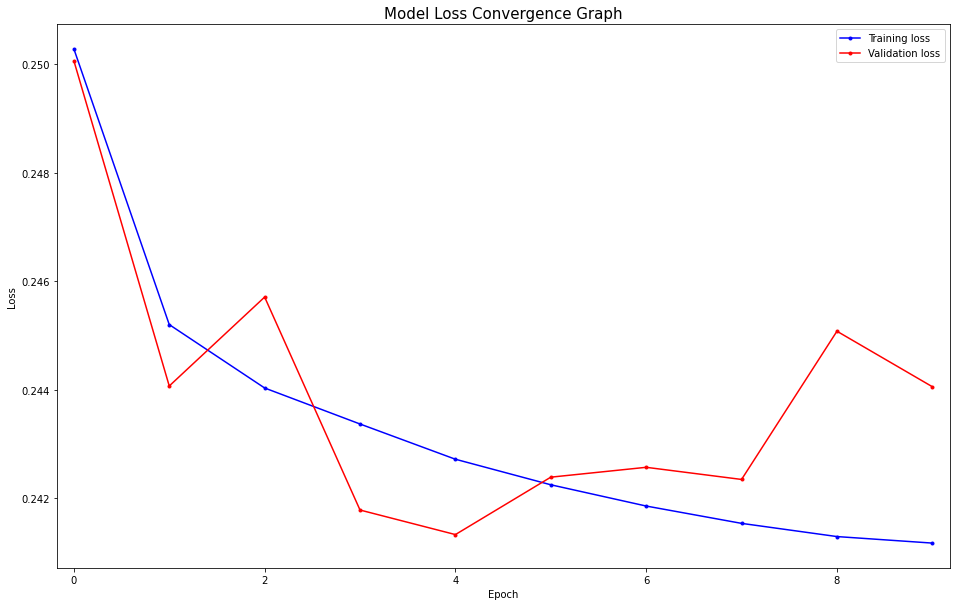

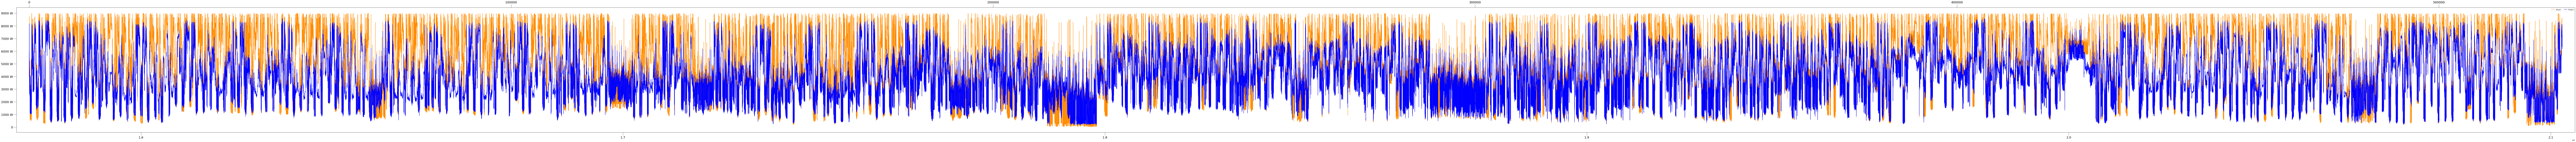

In [10]:
Auto_Scaler_lr_filt_kernel_merge_case(QuantileTransformer(), 0.0004, 8, 4, "ave", 6)